<h1 align = 'center'><b>HOTEL NEIGHBORHOODS SCORING MODEL</b></h1>

# 0. Prepare Enviroment

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np
import time
import json # library to handle JSON files
#!pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
#import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import r2_score
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

# 1. Get Selina Occupancy Rates and Coordinates in a Data Frame

In [2]:
Selina_Occupancy_html = pd.read_html('https://docs.google.com/spreadsheets/d/e/2PACX-1vR2UIrUWim0MlJYODYqxaYfux0Ej27gpm839U5qD3MbkoRaxmXzbD7BHoRndq8YT7aUGuJQGM0h47JV/pubhtml?gid=2065855408&single=true')
Selina_Occupancy = pd.DataFrame(Selina_Occupancy_html[0])
new_header = Selina_Occupancy.iloc[0] #grab the first row for the header
Selina_Occupancy = Selina_Occupancy[1:] #take the data less the header row
Selina_Occupancy.columns = new_header #set the header row as the df header
Selina_Occupancy.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True) #Drop empty rows
Selina_Occupancy.set_index(1, inplace = True)
Selina_Occupancy.head(10)

,Region,Country,City,Adress,Coordinates,Latitude,Longitude,Name,Averga Occupancy,BUSINESS ID,OPENING DATE
1,,,,,,,,,,,
3,Latam,Costa Rica,Manuel Antonio,"Km 5 Manuel Antonio, Provincia de Puntarenas, ...","9.402510, -84.152652",9.40251,-84.152652,CASITAS ECLIPSE/CONDO I,0.75,447,11/1/2016
4,Latam,Costa Rica,San Jose,"Avenida 9, Calle 15, Barrio AmÃ³n San JosÃ©, C...","9.937397, -84.072219",9.937397,-84.072219,EL RINCON,0.94,355,11/1/2016
5,Latam,Costa Rica,Santa Teresa,"Brunela, Santa Teresa Beach, Puntarenas, Costa...","9.641762, -85.165207",9.641762,-85.165207,LA BRUNELA,0.80,384,12/1/2016
6,Latam,Colombia,Medellin,"Cra. 32d #9-17, MedellÃ­n, Antioquia, Colombia","6.207870, -75.564037",6.20787,-75.564037,PLAZA ROSA,0.97,400,7/1/2017
9,Latam,Mexico,Playa del Carmen,"Calle 2 Nte 2, Centro, 77710 Playa del Carmen,...","20.623832, -87.074927",20.623832,-87.074927,HOTEL MAYELI,0.96,467,2/5/2018
10,Latam,Costa Rica,Puerta a la Vida,"Heredia Province, San Isidro, 40601,Calle 144,...","10.047829, -84.733586",10.047829,-84.733586,PUERTA A LA VIDA,0.08,406,2/26/2018
11,Latam,Costa Rica,Santa Teresa,400 meters north of Franks Place | Playa Carme...,"9.631111, -85.152846",9.631111,-85.152846,TRANQUILO,0.92,424,2/27/2018
12,Latam,Ecuador,Quito,Diego de Almagro N24-416 y Luis Cordero,"-0.201813, -78.488314",-0.201813,-78.488314,Hotel Sebastian,0.90,630,6/18/2018
14,Latam,Ecuador,Cuenca,"Calle Larga 7-93 y Luis Cordero, Calle Larga, ...","-2.901291, -79.004647",-2.901291,-79.004647,Crespo,0.86,485,10/25/2018


In [3]:
Selina_Occupancy.shape

(37, 11)

# 2. For each Selina Location get the following data from Forsquare:
1. Number of restaurants
2. Number Hotels
3. Number Hostels
4. Number Coworks
5. Number Restaurants
6. Number Yoga Venues

#### 2.1  Define Foursquare Credentials and Version

In [31]:
CLIENT_ID = 'UFTEEZV4E3A0QIOEA1GN3HB5VOUO34FAK4I2JSOUTFDH1QVZ' # your Foursquare ID
CLIENT_SECRET = 'UWX0IZDV231DCDSMCNQBG20ELCCIIGPTXD2ZLHKYO14DSXAD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### 2.2 Define search paramenters, create the GET request URL, transfor to Pandas df and print number of venues

#### 2.2.1 Add a coluumn with the number of hotels around each location  

In [32]:
hotels_list = []
row = next(Selina_Occupancy.iterrows())[1]
for index, row in Selina_Occupancy.iterrows():
    try:
        search_query = 'hotel' #Change to query each category
        LIMIT = 500 
        radius = 1000 
        latitude = row.Latitude 
        longitude = row.Longitude
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        d = {}
        d['Hotel_Count']=dataframe['name'].count() #Rename the column
        d['Name']=row.Name
        hotels_list.append(d) #Rename the list
    except:
        d['Hotel_Count']=0 #Rename the column
        d['Name']=row.Name
        hotels_list.append(d) #Rename the list
        continue
das_hotel = pd.DataFrame(hotels_list) #Rename the list
Selina_Occupancy = Selina_Occupancy.join(das_hotel.set_index('Name'), on='Name') #Rename the list
Selina_Occupancy.head()

,Region,Country,City,Adress,Coordinates,Latitude,Longitude,Name,Averga Occupancy,BUSINESS ID,OPENING DATE,Hotel_Count
1,,,,,,,,,,,,
3,Latam,Costa Rica,Manuel Antonio,"Km 5 Manuel Antonio, Provincia de Puntarenas, ...","9.402510, -84.152652",9.40251,-84.152652,CASITAS ECLIPSE/CONDO I,0.75,447,11/1/2016,27
4,Latam,Costa Rica,San Jose,"Avenida 9, Calle 15, Barrio AmÃ³n San JosÃ©, C...","9.937397, -84.072219",9.937397,-84.072219,EL RINCON,0.94,355,11/1/2016,50
5,Latam,Costa Rica,Santa Teresa,"Brunela, Santa Teresa Beach, Puntarenas, Costa...","9.641762, -85.165207",9.641762,-85.165207,LA BRUNELA,0.80,384,12/1/2016,11
6,Latam,Colombia,Medellin,"Cra. 32d #9-17, MedellÃ­n, Antioquia, Colombia","6.207870, -75.564037",6.20787,-75.564037,PLAZA ROSA,0.97,400,7/1/2017,50
9,Latam,Mexico,Playa del Carmen,"Calle 2 Nte 2, Centro, 77710 Playa del Carmen,...","20.623832, -87.074927",20.623832,-87.074927,HOTEL MAYELI,0.96,467,2/5/2018,50


#### 2.2.2 Add a coluumn with the number of hostels around each location  

In [9]:
hostel_list = [] #Rename the list
row = next(Selina_Occupancy.iterrows())[1]
for index, row in Selina_Occupancy.iterrows():
    try:
        search_query = 'hostel' #Change to query each category
        LIMIT = 500 
        radius = 1000 
        latitude = row.Latitude 
        longitude = row.Longitude
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        d = {}
        d['Hostel_Count']=dataframe['name'].count() #Rename the column
        d['Name']=row.Name
        hostel_list.append(d) #Rename the list
    except:
        d['Hostel_Count']=0 #Rename the column
        d['Name']=row.Name
        hostel_list.append(d) #Rename the list
        continue
das_hostel = pd.DataFrame(hostel_list) #Rename the list
Selina_Occupancy = Selina_Occupancy.join(das_hostel.set_index('Name'), on='Name') #Rename the list
Selina_Occupancy.head()

,Region,Country,City,Adress,Coordinates,Latitude,Longitude,Name,Averga Occupancy,BUSINESS ID,OPENING DATE,Hotel_Count,Hostel_Count
1,,,,,,,,,,,,,
3,Latam,Costa Rica,Manuel Antonio,"Km 5 Manuel Antonio, Provincia de Puntarenas, ...","9.402510, -84.152652",9.40251,-84.152652,CASITAS ECLIPSE/CONDO I,0.75,447,11/1/2016,27,4
4,Latam,Costa Rica,San Jose,"Avenida 9, Calle 15, Barrio AmÃ³n San JosÃ©, C...","9.937397, -84.072219",9.937397,-84.072219,EL RINCON,0.94,355,11/1/2016,50,16
5,Latam,Costa Rica,Santa Teresa,"Brunela, Santa Teresa Beach, Puntarenas, Costa...","9.641762, -85.165207",9.641762,-85.165207,LA BRUNELA,0.80,384,12/1/2016,11,5
6,Latam,Colombia,Medellin,"Cra. 32d #9-17, MedellÃ­n, Antioquia, Colombia","6.207870, -75.564037",6.20787,-75.564037,PLAZA ROSA,0.97,400,7/1/2017,50,31
9,Latam,Mexico,Playa del Carmen,"Calle 2 Nte 2, Centro, 77710 Playa del Carmen,...","20.623832, -87.074927",20.623832,-87.074927,HOTEL MAYELI,0.96,467,2/5/2018,50,28


#### 2.2.3 Add a coluumn with the number of coworks around each location  

In [10]:
Cowork_list = [] #Rename the list
row = next(Selina_Occupancy.iterrows())[1]
for index, row in Selina_Occupancy.iterrows():
    try:
        search_query = 'cowork' #Change to query each category
        LIMIT = 500 
        radius = 1000 
        latitude = row.Latitude 
        longitude = row.Longitude
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        d = {}
        d['Cowork_Count']=dataframe['name'].count() #Rename the column
        d['Name']=row.Name
        Cowork_list.append(d) #Rename the list
    except:
        d['Cowork_Count']=0 #Rename the column
        d['Name']=row.Name
        Cowork_list.append(d) #Rename the list
        continue
das_cowork = pd.DataFrame(Cowork_list) #Rename the list
Selina_Occupancy = Selina_Occupancy.join(das_cowork.set_index('Name'), on='Name') #Rename the list
Selina_Occupancy.head()

,Region,Country,City,Adress,Coordinates,Latitude,Longitude,Name,Averga Occupancy,BUSINESS ID,OPENING DATE,Hotel_Count,Hostel_Count,Cowork_Count
1,,,,,,,,,,,,,,
3,Latam,Costa Rica,Manuel Antonio,"Km 5 Manuel Antonio, Provincia de Puntarenas, ...","9.402510, -84.152652",9.40251,-84.152652,CASITAS ECLIPSE/CONDO I,0.75,447,11/1/2016,27,4,1
4,Latam,Costa Rica,San Jose,"Avenida 9, Calle 15, Barrio AmÃ³n San JosÃ©, C...","9.937397, -84.072219",9.937397,-84.072219,EL RINCON,0.94,355,11/1/2016,50,16,2
5,Latam,Costa Rica,Santa Teresa,"Brunela, Santa Teresa Beach, Puntarenas, Costa...","9.641762, -85.165207",9.641762,-85.165207,LA BRUNELA,0.80,384,12/1/2016,11,5,0
6,Latam,Colombia,Medellin,"Cra. 32d #9-17, MedellÃ­n, Antioquia, Colombia","6.207870, -75.564037",6.20787,-75.564037,PLAZA ROSA,0.97,400,7/1/2017,50,31,9
9,Latam,Mexico,Playa del Carmen,"Calle 2 Nte 2, Centro, 77710 Playa del Carmen,...","20.623832, -87.074927",20.623832,-87.074927,HOTEL MAYELI,0.96,467,2/5/2018,50,28,2


#### 2.2.4 Add a coluumn with the number of restaurants around each location  

In [11]:
Restaurant_list = [] #Rename the list
row = next(Selina_Occupancy.iterrows())[1]
for index, row in Selina_Occupancy.iterrows():
    try:
        search_query = 'restaurant' #Change to query each category
        LIMIT = 500 
        radius = 1000 
        latitude = row.Latitude 
        longitude = row.Longitude
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        d = {}
        d['Restaurant_Count']=dataframe['name'].count() #Rename the column
        d['Name']=row.Name
        Restaurant_list.append(d) #Rename the list
    except:
        d['Restaurant_Count']=0 #Rename the column
        d['Name']=row.Name
        Restaurant_list.append(d) #Rename the list
        continue
das_restaurant = pd.DataFrame(Restaurant_list) #Rename the list
Selina_Occupancy = Selina_Occupancy.join(das_restaurant.set_index('Name'), on='Name') #Rename the list
Selina_Occupancy.head()

,Region,Country,City,Adress,Coordinates,Latitude,Longitude,Name,Averga Occupancy,BUSINESS ID,OPENING DATE,Hotel_Count,Hostel_Count,Cowork_Count,Restaurant_Count
1,,,,,,,,,,,,,,,
3,Latam,Costa Rica,Manuel Antonio,"Km 5 Manuel Antonio, Provincia de Puntarenas, ...","9.402510, -84.152652",9.40251,-84.152652,CASITAS ECLIPSE/CONDO I,0.75,447,11/1/2016,27,4,1,22
4,Latam,Costa Rica,San Jose,"Avenida 9, Calle 15, Barrio AmÃ³n San JosÃ©, C...","9.937397, -84.072219",9.937397,-84.072219,EL RINCON,0.94,355,11/1/2016,50,16,2,50
5,Latam,Costa Rica,Santa Teresa,"Brunela, Santa Teresa Beach, Puntarenas, Costa...","9.641762, -85.165207",9.641762,-85.165207,LA BRUNELA,0.80,384,12/1/2016,11,5,0,4
6,Latam,Colombia,Medellin,"Cra. 32d #9-17, MedellÃ­n, Antioquia, Colombia","6.207870, -75.564037",6.20787,-75.564037,PLAZA ROSA,0.97,400,7/1/2017,50,31,9,50
9,Latam,Mexico,Playa del Carmen,"Calle 2 Nte 2, Centro, 77710 Playa del Carmen,...","20.623832, -87.074927",20.623832,-87.074927,HOTEL MAYELI,0.96,467,2/5/2018,50,28,2,50


#### 2.2.5 Add a coluumn with the number of yoga studios around each location  

In [12]:
Yoga_list = [] #Rename the list
row = next(Selina_Occupancy.iterrows())[1]
for index, row in Selina_Occupancy.iterrows():
    try:
        search_query = 'yoga' #Change to query each category
        LIMIT = 500 
        radius = 1000 
        latitude = row.Latitude 
        longitude = row.Longitude
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        d = {}
        d['Yoga_Count']=dataframe['name'].count() #Rename the column
        d['Name']=row.Name
        Yoga_list.append(d) #Rename the list
    except:
        d['Yoga_Count']=0 #Rename the column
        d['Name']=row.Name
        Yoga_list.append(d) #Rename the list
        continue
das_yoga = pd.DataFrame(Yoga_list) #Rename the list
Selina_Occupancy = Selina_Occupancy.join(das_yoga.set_index('Name'), on='Name') #Rename the list
Selina_Occupancy.head()

,Region,Country,City,Adress,Coordinates,Latitude,Longitude,Name,Averga Occupancy,BUSINESS ID,OPENING DATE,Hotel_Count,Hostel_Count,Cowork_Count,Restaurant_Count,Yoga_Count
1,,,,,,,,,,,,,,,,
3,Latam,Costa Rica,Manuel Antonio,"Km 5 Manuel Antonio, Provincia de Puntarenas, ...","9.402510, -84.152652",9.40251,-84.152652,CASITAS ECLIPSE/CONDO I,0.75,447,11/1/2016,27,4,1,22,1
4,Latam,Costa Rica,San Jose,"Avenida 9, Calle 15, Barrio AmÃ³n San JosÃ©, C...","9.937397, -84.072219",9.937397,-84.072219,EL RINCON,0.94,355,11/1/2016,50,16,2,50,11
5,Latam,Costa Rica,Santa Teresa,"Brunela, Santa Teresa Beach, Puntarenas, Costa...","9.641762, -85.165207",9.641762,-85.165207,LA BRUNELA,0.80,384,12/1/2016,11,5,0,4,3
6,Latam,Colombia,Medellin,"Cra. 32d #9-17, MedellÃ­n, Antioquia, Colombia","6.207870, -75.564037",6.20787,-75.564037,PLAZA ROSA,0.97,400,7/1/2017,50,31,9,50,8
9,Latam,Mexico,Playa del Carmen,"Calle 2 Nte 2, Centro, 77710 Playa del Carmen,...","20.623832, -87.074927",20.623832,-87.074927,HOTEL MAYELI,0.96,467,2/5/2018,50,28,2,50,8


#### 2.2.6 Add a coluumn with the number of total venues around each location  

In [13]:
Venues_list = [] #Rename the list
row = next(Selina_Occupancy.iterrows())[1]
for index, row in Selina_Occupancy.iterrows():
    try:
        search_query = '' #Change to query each category
        LIMIT = 500 
        radius = 1000 
        latitude = row.Latitude 
        longitude = row.Longitude
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        d = {}
        d['Venues_Count']=dataframe['name'].count() #Rename the column
        d['Name']=row.Name
        Venues_list.append(d) #Rename the list
    except:
        d['Venues_Count']=0 #Rename the column
        d['Name']=row.Name
        Venues_list.append(d) #Rename the list
        continue
das_venues = pd.DataFrame(Venues_list) #Rename the list
Selina_Occupancy = Selina_Occupancy.join(das_venues.set_index('Name'), on='Name') #Rename the list
Selina_Occupancy.head()

,Region,Country,City,Adress,Coordinates,Latitude,Longitude,Name,Averga Occupancy,BUSINESS ID,OPENING DATE,Hotel_Count,Hostel_Count,Cowork_Count,Restaurant_Count,Yoga_Count,Venues_Count
1,,,,,,,,,,,,,,,,,
3,Latam,Costa Rica,Manuel Antonio,"Km 5 Manuel Antonio, Provincia de Puntarenas, ...","9.402510, -84.152652",9.40251,-84.152652,CASITAS ECLIPSE/CONDO I,0.75,447,11/1/2016,27,4,1,22,1,125
4,Latam,Costa Rica,San Jose,"Avenida 9, Calle 15, Barrio AmÃ³n San JosÃ©, C...","9.937397, -84.072219",9.937397,-84.072219,EL RINCON,0.94,355,11/1/2016,50,16,2,50,11,125
5,Latam,Costa Rica,Santa Teresa,"Brunela, Santa Teresa Beach, Puntarenas, Costa...","9.641762, -85.165207",9.641762,-85.165207,LA BRUNELA,0.80,384,12/1/2016,11,5,0,4,3,115
6,Latam,Colombia,Medellin,"Cra. 32d #9-17, MedellÃ­n, Antioquia, Colombia","6.207870, -75.564037",6.20787,-75.564037,PLAZA ROSA,0.97,400,7/1/2017,50,31,9,50,8,113
9,Latam,Mexico,Playa del Carmen,"Calle 2 Nte 2, Centro, 77710 Playa del Carmen,...","20.623832, -87.074927",20.623832,-87.074927,HOTEL MAYELI,0.96,467,2/5/2018,50,28,2,50,8,124


In [14]:
filtered_db = Selina_Occupancy[['Country','Name','Hotel_Count','Hostel_Count','Cowork_Count','Restaurant_Count','Yoga_Count','Venues_Count']]
filtered_db.head(10)

,Country,Name,Hotel_Count,Hostel_Count,Cowork_Count,Restaurant_Count,Yoga_Count,Venues_Count
1,,,,,,,,
3,Costa Rica,CASITAS ECLIPSE/CONDO I,27,4,1,22,1,125
4,Costa Rica,EL RINCON,50,16,2,50,11,125
5,Costa Rica,LA BRUNELA,11,5,0,4,3,115
6,Colombia,PLAZA ROSA,50,31,9,50,8,113
9,Mexico,HOTEL MAYELI,50,28,2,50,8,124
10,Costa Rica,PUERTA A LA VIDA,0,0,0,0,0,109
11,Costa Rica,TRANQUILO,23,12,1,10,4,116
12,Ecuador,Hotel Sebastian,50,10,2,50,8,124
14,Ecuador,Crespo,50,7,1,50,1,120


# 3. Build a Prediction Model to determine the Occupancy Rates

The hipotesis of this model is that locations with a higher percentages of brand related venues  (hotel, hostelsm coworks, restaurants, and yoga studios) vs the total venues will yield higher occupancy rates since are target markets for Selina target audience. We will build, train and test a model to predict Occupancy rates based on this independable variables

#### 3.1 Convert the Average Occupancy to a float

In [15]:
Selina_Occupancy = Selina_Occupancy.rename(columns={'Averga Occupancy': 'AVG_OCCUPANCY'})
Selina_Occupancy["AVG_OCCUPANCY"] = pd.to_numeric(Selina_Occupancy["AVG_OCCUPANCY"], downcast="float")

#### 3.2 Make a figure with 6 charts to evaluate if the venues have a direct relationship with the Ocupancy

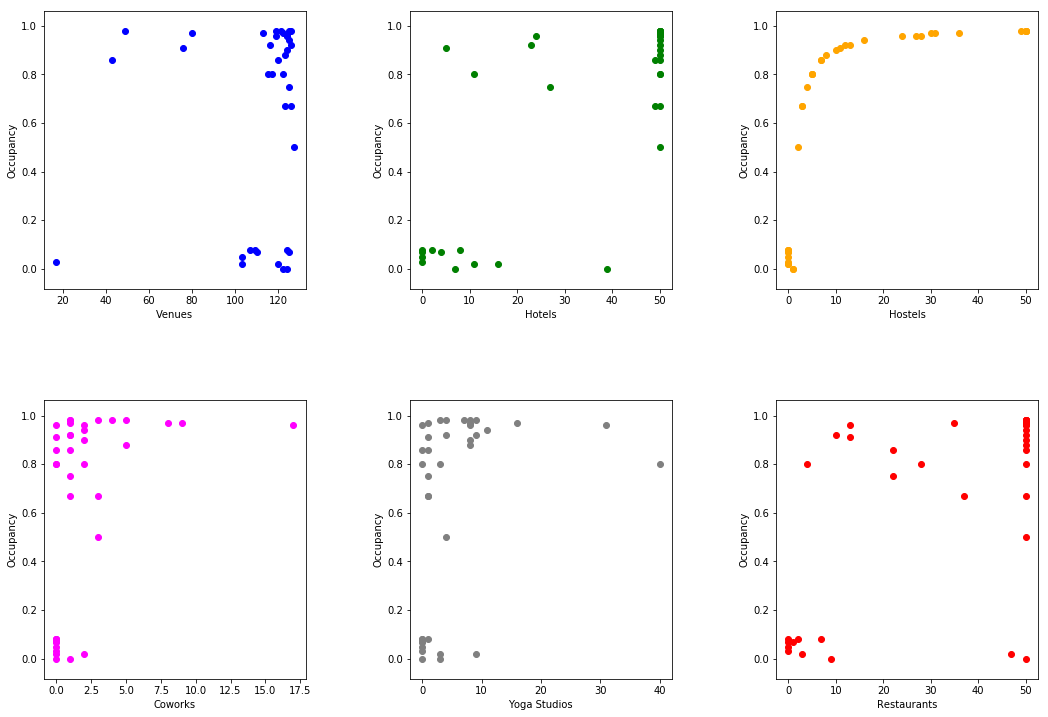

In [16]:
# plot with various axes scales
plt.figure()

# Venues
plt.subplot(231)
plt.scatter(Selina_Occupancy.Venues_Count, Selina_Occupancy.AVG_OCCUPANCY,  color='blue')
plt.xlabel("Venues")
plt.ylabel("Occupancy")

# Hotels
plt.subplot(232)
plt.scatter(Selina_Occupancy.Hotel_Count, Selina_Occupancy.AVG_OCCUPANCY,  color='Green')
plt.xlabel("Hotels")
plt.ylabel("Occupancy")


# Hostels
plt.subplot(233)
plt.scatter(Selina_Occupancy.Hostel_Count, Selina_Occupancy.AVG_OCCUPANCY,  color='Orange')
plt.xlabel("Hostels")
plt.ylabel("Occupancy")

# Coworks
plt.subplot(234)
plt.scatter(Selina_Occupancy.Cowork_Count, Selina_Occupancy.AVG_OCCUPANCY,  color='Magenta')
plt.xlabel("Coworks")
plt.ylabel("Occupancy")

# Yoga Studios
plt.subplot(235)
plt.scatter(Selina_Occupancy.Yoga_Count, Selina_Occupancy.AVG_OCCUPANCY,  color='gray')
plt.xlabel("Yoga Studios")
plt.ylabel("Occupancy")

# Restaurants
plt.subplot(236)
plt.scatter(Selina_Occupancy.Restaurant_Count, Selina_Occupancy.AVG_OCCUPANCY,  color='red')
plt.xlabel("Restaurants")
plt.ylabel("Occupancy")

plt.subplots_adjust(top=2.4, bottom=0.08, left=0.10, right=2.4, hspace=0.4, wspace=0.4)
plt.show()

# 4. Build a non-linear prediction model for Occupancy Rate based only in Hostels Count

We can evidence in the cahrts above that the only clear relationship exist between the number of Hostels and Occupancy Rate, therefore the prediction model will be based only using this variables

#### 4.1 Plot Occupancy vs Vennues to understand the relationship

In [17]:
Selina_Occupancy["Hostel_Count"] = pd.to_numeric(Selina_Occupancy["Hostel_Count"], downcast="float")

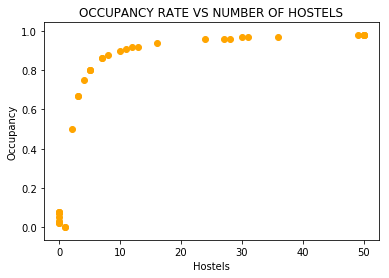

In [18]:
plt.scatter(Selina_Occupancy.Hostel_Count, Selina_Occupancy.AVG_OCCUPANCY,  color='orange')
plt.xlabel("Hostels")
plt.ylabel("Occupancy")
plt.title('OCCUPANCY RATE VS NUMBER OF HOSTELS')
plt.show()

#### 4.2 Filter the DataFrame

In [19]:
df = Selina_Occupancy[['AVG_OCCUPANCY','Hostel_Count']]
df.head()

,AVG_OCCUPANCY,Hostel_Count
1,,
3,0.75,4.0
4,0.94,16.0
5,0.80,5.0
6,0.97,31.0
9,0.96,28.0


#### 4.3 Create and train a data set

In [46]:
msk = np.random.rand(len(Selina_Occupancy)) < 0.8
train = df[msk]
test = df[~msk]

In [47]:
train_x = np.asanyarray(train[['Hostel_Count']])
train_y = np.asanyarray(train[['AVG_OCCUPANCY']])

test_x = np.asanyarray(test[['Hostel_Count']])
test_y = np.asanyarray(test[['AVG_OCCUPANCY']])


poly = PolynomialFeatures(degree=3)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

array([[1.00000e+00, 4.00000e+00, 1.60000e+01, 6.40000e+01],
       [1.00000e+00, 1.60000e+01, 2.56000e+02, 4.09600e+03],
       [1.00000e+00, 5.00000e+00, 2.50000e+01, 1.25000e+02],
       [1.00000e+00, 3.10000e+01, 9.61000e+02, 2.97910e+04],
       [1.00000e+00, 2.80000e+01, 7.84000e+02, 2.19520e+04],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.20000e+01, 1.44000e+02, 1.72800e+03],
       [1.00000e+00, 1.00000e+01, 1.00000e+02, 1.00000e+03],
       [1.00000e+00, 7.00000e+00, 4.90000e+01, 3.43000e+02],
       [1.00000e+00, 3.00000e+00, 9.00000e+00, 2.70000e+01],
       [1.00000e+00, 1.30000e+01, 1.69000e+02, 2.19700e+03],
       [1.00000e+00, 5.00000e+01, 2.50000e+03, 1.25000e+05],
       [1.00000e+00, 4.90000e+01, 2.40100e+03, 1.17649e+05],
       [1.00000e+00, 2.00000e+00, 4.00000e+00, 8.00000e+00],
       [1.00000e+00, 5.00000e+01, 2.50000e+03, 1.25000e+05],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.00000e+00, 0.0

#### 4.4 Create a Non Linear Regression Analysis

In [48]:
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.0000000e+00  1.3628687e-01 -5.5145109e-03  6.2970816e-05]]
Intercept:  [0.10154861]


#### 4.5 Evaluate the model to guarantee that the predictions will be accurated

In [49]:
test_x_poly = poly.fit_transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

Mean absolute error: 0.06
Residual sum of squares (MSE): 0.00
R2-score: 0.98


# Bonus to used with the Premium API

Perosnal API has some limitiation in the number of calls I can make to retrieve additional information of the venues like raiting, menus, tips, photos, etc. Therefore we will lieave this section for calls that we can later use with the primum API

In [42]:
search_query = '' #Change to query each category
, 
LIMIT = 1000 
radius = 50000
latitude = 6.247549 
longitude = -75.591015
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        latitude, 
        longitude, 
        VERSION, 
        search_query, 
        radius, 
        LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb4afa2d03993001b92b2cb'},
 'response': {'venues': [{'id': '4d1393bd0ad2f04d9f9db454',
    'name': 'Órale',
    'location': {'lat': 6.247298910670887,
     'lng': -75.59037279582813,
     'labeledLatLngs': [{'label': 'display',
       'lat': 6.247298910670887,
       'lng': -75.59037279582813}],
     'distance': 76,
     'cc': 'CO',
     'city': 'Medellín',
     'state': 'Antioquia',
     'country': 'Colombia',
     'formattedAddress': ['Medellín, Antioquia', 'Colombia']},
    'categories': [{'id': '4bf58dd8d48988d1c1941735',
      'name': 'Mexican Restaurant',
      'pluralName': 'Mexican Restaurants',
      'shortName': 'Mexican',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1588899848',
    'hasPerk': False},
   {'id': '51816b7f498e272982144478',
    'name': 'Gourmet Marino',
    'location': {'lat': 6.246859,
     'lng': -75.590448,
     '

In [43]:
venue_id = '59cab657270ee755163961e0' #Selina Cowork
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/59cab657270ee755163961e0?client_id=UFTEEZV4E3A0QIOEA1GN3HB5VOUO34FAK4I2JSOUTFDH1QVZ&client_secret=UWX0IZDV231DCDSMCNQBG20ELCCIIGPTXD2ZLHKYO14DSXAD&v=20180605'

In [44]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

KeyError: 'venue'

In [45]:
venues = results['response']['venues']
dataframe222 = json_normalize(venues)
dataframe222

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",False,4d1393bd0ad2f04d9f9db454,NaN,CO,Medellín,Colombia,NaN,76,"[Medellín, Antioquia, Colombia]","[{'label': 'display', 'lat': 6.247298910670887...",6.247299,-75.590373,NaN,NaN,Antioquia,Órale,v-1588899848
1,"[{'id': '4bf58dd8d48988d144941735', 'name': 'C...",False,51816b7f498e272982144478,NaN,CO,NaN,Colombia,NaN,99,[Colombia],"[{'label': 'display', 'lat': 6.246859, 'lng': ...",6.246859,-75.590448,NaN,NaN,NaN,Gourmet Marino,v-1588899848
2,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",False,4e417463d164f2d277c33264,NaN,CO,NaN,Colombia,NaN,71,[Colombia],"[{'label': 'display', 'lat': 6.24810918187131,...",6.248109,-75.590705,NaN,NaN,NaN,Restaurante Pomodoro,v-1588899848
3,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",False,5047fc33e4b0fbb311c3205e,NaN,CO,Medellín,Colombia,NaN,93,"[Medellín, Antioquia, Colombia]","[{'label': 'display', 'lat': 6.248298478169146...",6.248298,-75.590626,NaN,NaN,Antioquia,Pomo d'Oro,v-1588899848
4,"[{'id': '4bf58dd8d48988d110951735', 'name': 'S...",False,576983b2498eb7212ea6eba8,Calle 42 #71A,CO,Medellín,Colombia,NaN,59,"[Calle 42 #71A, Medellín, Antioquia, Colombia]","[{'label': 'display', 'lat': 6.24808, 'lng': -...",6.248080,-75.591030,Bolivariana,NaN,Antioquia,Premium Cavaliere Barbershop,v-1588899848
5,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",False,4d90d02e3bfef04dc3aecb86,NaN,CO,NaN,Colombia,NaN,319,[Colombia],"[{'label': 'display', 'lat': 6.24603299955067,...",6.246033,-75.593469,NaN,NaN,NaN,Primer Parque de Laureles,v-1588899848
6,"[{'id': '4bf58dd8d48988d152941735', 'name': 'A...",False,4ef3c64602d574894f321ad1,Circular 5 # 71A - 38,CO,Medellín,Colombia,NaN,92,"[Circular 5 # 71A - 38, Medellín, Antioquia, C...","[{'label': 'display', 'lat': 6.246804063983479...",6.246804,-75.591377,NaN,NaN,Antioquia,Arepitas de Antaño Laureles,v-1588899848
7,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",False,518c33c2498e6fce6d7becd4,Carrera 71 Circular 4-09,CO,NaN,Colombia,NaN,125,"[Carrera 71 Circular 4-09, Colombia]","[{'label': 'display', 'lat': 6.246604739547445...",6.246605,-75.590403,NaN,NaN,NaN,Nuovo Fiore,v-1588899848
8,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",False,57cf6241cd105a788083ab00,Circular 5 # 70-56,CO,Medellín,Colombia,NaN,151,"[Circular 5 # 70-56, Medellín, Antioquia, Colo...","[{'label': 'display', 'lat': 6.247242, 'lng': ...",6.247242,-75.589684,NaN,NaN,Antioquia,Full Árabe,v-1588899848
9,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4e8125258b812e9ebac2b806,NaN,CO,Medellín,Colombia,NaN,86,"[Medellín, Antióquia, Colombia]","[{'label': 'display', 'lat': 6.247371261897073...",6.247371,-75.591775,NaN,NaN,Antióquia,Hotel Casa Blanca,v-1588899848


In [47]:
row = next(dataframe222.iterrows())[1]
for index, row in dataframe222.iterrows():
    try:
        venue_id = row.id
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        print(result['response']['venue']['name'], result['response']['venue']['rating'])
    except:
        #print(result['response']['venue']['name'], 'NA')
        continue

In [33]:
Selina_Occupancy.head()

,Region,Country,City,Adress,Coordinates,Latitude,Longitude,Name,Averga Occupancy,BUSINESS ID,OPENING DATE,Hotel_Count
1,,,,,,,,,,,,
3,Latam,Costa Rica,Manuel Antonio,"Km 5 Manuel Antonio, Provincia de Puntarenas, ...","9.402510, -84.152652",9.40251,-84.152652,CASITAS ECLIPSE/CONDO I,0.75,447,11/1/2016,27
4,Latam,Costa Rica,San Jose,"Avenida 9, Calle 15, Barrio AmÃ³n San JosÃ©, C...","9.937397, -84.072219",9.937397,-84.072219,EL RINCON,0.94,355,11/1/2016,50
5,Latam,Costa Rica,Santa Teresa,"Brunela, Santa Teresa Beach, Puntarenas, Costa...","9.641762, -85.165207",9.641762,-85.165207,LA BRUNELA,0.80,384,12/1/2016,11
6,Latam,Colombia,Medellin,"Cra. 32d #9-17, MedellÃ­n, Antioquia, Colombia","6.207870, -75.564037",6.20787,-75.564037,PLAZA ROSA,0.97,400,7/1/2017,50
9,Latam,Mexico,Playa del Carmen,"Calle 2 Nte 2, Centro, 77710 Playa del Carmen,...","20.623832, -87.074927",20.623832,-87.074927,HOTEL MAYELI,0.96,467,2/5/2018,50


In [ ]:
hotels_list = []
row = next(Selina_Occupancy.iterrows())[1]
for index, row in Selina_Occupancy.iterrows():
    try:
        search_query = 'hotel' #Change to query each category
        LIMIT = 500 
        radius = 1000 
        latitude = row.Latitude 
        longitude = row.Longitude
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        d = {}
        d['Hotel_Count']=dataframe['name'].count() #Rename the column
        d['Name']=row.Name
        hotels_list.append(d) #Rename the list
    except:
        d['Hotel_Count']=0 #Rename the column
        d['Name']=row.Name
        hotels_list.append(d) #Rename the list
        continue
das_hotel = pd.DataFrame(hotels_list) #Rename the list
Selina_Occupancy = Selina_Occupancy.join(das_hotel.set_index('Name'), on='Name') #Rename the list
Selina_Occupancy.head()

In [38]:
search_query = '' #Change to query each category
, 
LIMIT = 500 
radius = 1000
latitude = 6.247549 
longitude = -75.591015
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        latitude, 
        longitude, 
        VERSION, 
        search_query, 
        radius, 
        LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe222 = json_normalize(venues)
row = next(dataframe222.iterrows())[1]
for index, row in dataframe222.iterrows():
    try:
        venue_id = row.id
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        print(result['response']['venue']['name'])
    except:
        #print(result['response']['venue']['name'], 'NA')
        continue